In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import pywt

In [2]:
import matplotlib.pyplot as plt

In [3]:
df1 = pd.read_csv('train.csv')
df2= pd.read_csv('test.csv')
dt = pd.read_csv('real_result_20perc.csv')

In [4]:
df1.replace(['-999', -999], np.nan, inplace=True)

In [5]:
df1['ZDEN'][df1['ZDEN']<0] = np.nan
df1['GR'][df1['GR']<0] = np.nan
df1['CNC'][df1['CNC']<0] = np.nan
df1['PE'][df1['PE']<0] = np.nan

In [6]:
# GR
df1['GR'][(df1['GR']>250)] = np.nan
# CNC
df1['CNC'][df1['CNC']>0.7] = np.nan
# HRM & HRD
df1['HRD'][df1['HRD']>200] = np.nan
df1['HRM'][df1['HRM']>200] = np.nan

In [7]:
df1['HRM'] = df1['HRM'].apply(lambda x:np.log(x))
df1['HRD'] = df1['HRD'].apply(lambda x:np.log(x))

In [8]:
#This function is defined for descrete wavelet transform and calculating the cA ie the approximate coefficient
def make_dwt_vars_cA(wells_df,logs,levels,wavelet):

    wave= pywt.Wavelet(wavelet)
    
    grouped = wells_df
    new_df = pd.DataFrame()
    for key in grouped.keys():
    
        depth = grouped['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        for log in logs:
      
            temp_data = grouped[log]
              
            for i in levels:
                
                    cA_cD = pywt.wavedec(temp_data,wave,level=i,mode='symmetric')
                    cA = cA_cD[0]
                    new_depth = np.linspace(min(depth),max(depth),len(cA))
                    fA = interp1d(new_depth,cA,kind='nearest')
                    temp_df[log + '_cA_level_' + str(i)] = fA(depth)
    
        new_df = new_df.append(temp_df)
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Depth'],axis=1)
    return new_df

In [9]:
#This is a user defined function for discrte wavelet transform cD, cD is also called the detailed  coefficient
def make_dwt_vars_cD(wells_df,logs,levels,wavelet):

    wave= pywt.Wavelet(wavelet)
    
    grouped = wells_df
    new_df = pd.DataFrame()
    for key in grouped.keys():
    
        depth = grouped['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        for log in logs:
      
            temp_data = grouped[log]

            cA_4, cD_4, cD_3, cD_2, cD_1 = pywt.wavedec(temp_data,wave,level=4,mode='symmetric')
            dict_cD_levels = {1:cD_1, 2:cD_2, 3:cD_3, 4:cD_4}
                
            for i in levels:
                new_depth = np.linspace(min(depth),max(depth),len(dict_cD_levels[i]))
                fA = interp1d(new_depth,dict_cD_levels[i],kind='nearest')
                temp_df[log + '_cD_level_' + str(i)] = fA(depth)
    
        new_df = new_df.append(temp_df)
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Depth'],axis=1)
    return new_df

In [10]:
dt

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
0,8.6719,0.1199,6.7518,2.8285,3.0391,8.4395,2.5191,67.5481,124.2332
1,8.6719,0.3180,165.4345,1.3170,1.2206,7.1354,2.5517,101.5208,201.2649
2,8.7031,0.3164,58.3146,1.1627,1.8947,8.1722,2.4452,110.8297,250.7232
3,8.6250,0.1527,44.5126,2.5318,3.0052,7.6534,2.5674,80.0383,147.3262
4,8.6250,0.1731,16.1563,13.5082,13.0191,5.1534,2.2164,85.6109,134.4386
...,...,...,...,...,...,...,...,...,...
2212,8.6875,0.1228,9.4853,2.8712,3.0468,8.2976,2.5381,69.6183,127.9044
2213,8.6250,0.2245,42.9571,3.8252,4.5533,5.5709,2.2329,93.8871,146.5820
2214,8.5469,0.2401,31.6198,0.4185,0.3816,4.9895,2.2268,93.0115,161.6765
2215,8.6250,0.0667,6.1497,6.6133,6.5129,8.4379,2.6042,61.3967,112.0019


In [11]:
depth_train= np.linspace(500,4000,len(df1))
depth_dt= np.linspace(1500,3000,len(dt))

In [12]:
df1['Depth']= depth_train
dt['Depth']= depth_dt

Prediction with transformation

In [14]:
#cD From wavelet db4
dwt_db4_cD_df = make_dwt_vars_cD(wells_df=df1, logs=['CNC'],levels=[1, 2, 3, 4], wavelet='haar')

# cA From wavelet db4
dwt_db4_cA_df = make_dwt_vars_cA(wells_df=df1, logs=['CNC'],levels=[1, 2, 3, 4], wavelet='haar')

In [15]:
list_df_var = [dwt_db4_cD_df, dwt_db4_cA_df]
combined_df = df1
for var_df in list_df_var:
    temp_df = var_df
    combined_df = pd.concat([combined_df,temp_df],axis=1)
combined_df.replace(to_replace=np.nan, value='-1', inplace=True)
print (combined_df.shape)
training_data=combined_df

(301430, 18)


In [16]:
df1 = training_data

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# Create separate datasets for DTC and DTS
df_dtc = df1.dropna(subset=['DTC'])
df_dts = df1.dropna(subset=['DTS'])

In [25]:
df_dtc_x = df_dtc.drop(columns=['Depth'])
df_dts_x = df_dts.drop(columns=['Depth'])

In [26]:
#df_dtc_x = df_dtc.drop(columns=['DTC','DTS'])
#df_dts_x = df_dts.drop(columns=['DTC','DTS'])
y_dtc = df_dtc['DTC']
y_dts = df_dts['DTS']

X_train_dtc, X_test_dtc, y_train_dtc, y_test_dtc = train_test_split(df_dtc_x,y_dtc, test_size=0.30, random_state=42, shuffle = True)
X_train_dts, X_test_dts, y_train_dts, y_test_dts = train_test_split(df_dts_x,y_dts, test_size=0.30, random_state=42, shuffle = True)

In [27]:
import xgboost as xgb

For DTC

In [28]:
xgb_model_dtc = xgb.XGBRegressor(random_state=42, max_depth=2,learning_rate=0.18, n_estimators=145, min_child_weight = 6, gamma = 0.3)

In [29]:
from sklearn.metrics import r2_score, mean_squared_error

In [35]:
cols= X_train_dts.columns
for col in cols :
    X_train_dts[col]= X_train_dts[col].astype('float')
X_train_dts.dtypes

<ipython-input-35-6123859bbd5f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_dts[col]= X_train_dts[col].astype('float')


CAL               float64
CNC               float64
GR                float64
HRD               float64
HRM               float64
PE                float64
ZDEN              float64
DTC               float64
DTS               float64
CNC_cD_level_1    float64
CNC_cD_level_2    float64
CNC_cD_level_3    float64
CNC_cD_level_4    float64
CNC_cA_level_1    float64
CNC_cA_level_2    float64
CNC_cA_level_3    float64
CNC_cA_level_4    float64
dtype: object

In [32]:
cols= X_train_dtc.columns

In [33]:
for col in cols :
    X_train_dtc[col]= X_train_dtc[col].astype('float')
X_train_dtc.dtypes

<ipython-input-33-6b99cb9c3e45>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_dtc[col]= X_train_dtc[col].astype('float')


CAL               float64
CNC               float64
GR                float64
HRD               float64
HRM               float64
PE                float64
ZDEN              float64
DTC               float64
DTS               float64
CNC_cD_level_1    float64
CNC_cD_level_2    float64
CNC_cD_level_3    float64
CNC_cD_level_4    float64
CNC_cA_level_1    float64
CNC_cA_level_2    float64
CNC_cA_level_3    float64
CNC_cA_level_4    float64
dtype: object

In [34]:
xgb_model_dtc.fit(X_train_dtc, y_train_dtc)
y_pred_test_dtc = xgb_model_dtc.predict(X_test_dtc)
y_pred_train_dtc = xgb_model_dtc.predict(X_train_dtc)
print("RMSE_train:     " + str(np.sqrt(mean_squared_error(y_train_dtc,y_pred_train_dtc))))
print("RMSE_test:     " + str(np.sqrt(mean_squared_error(y_test_dtc,y_pred_test_dtc))))
print("R2_train:     " + str(r2_score(y_train_dtc,y_pred_train_dtc)))
print("R2_test:     " + str(r2_score(y_test_dtc,y_pred_test_dtc)))

RMSE_train:     0.3906521539811876
RMSE_test:     0.3940607189258664
R2_train:     0.9998992004356076
R2_test:     0.9998977547254873


For DTS

In [36]:
xgb_model_dts = xgb.XGBRegressor(random_state=42, max_depth=7,learning_rate=0.19, n_estimators=135, min_child_weight = 6, gamma = 0.7)

In [37]:
xgb_model_dts.fit(X_train_dts, y_train_dts)
y_pred_test_dts = xgb_model_dts.predict(X_test_dts)
y_pred_train_dts = xgb_model_dts.predict(X_train_dts)
print("RMSE_train:     " + str(np.sqrt(mean_squared_error(y_train_dts,y_pred_train_dts))))
print("RMSE_test:     " + str(np.sqrt(mean_squared_error(y_test_dts,y_pred_test_dts))))
print("R2_train:     " + str(r2_score(y_train_dts,y_pred_train_dts)))
print("R2_test:     " + str(r2_score(y_test_dts,y_pred_test_dts)))

RMSE_train:     0.1179749909685302
RMSE_test:     0.12137111930342806
R2_train:     0.9999986068431783
R2_test:     0.9999985240773671


Prediction on small test data

In [38]:
def result_plot(y_predict, y_real):
    # check the accuracy of predicted data and plot the result
    print('Combined r2 score is:', '{:.5f}'.format(np.sqrt(r2_score(y_real, y_predict))))
    dtc_real = y_real[:, 0]
    dtc_pred = y_predict[:, 0]
    dts_real = y_real[:, 1]
    dts_pred = y_predict[:, 1]
    print('DTC:', '{:.5f}'.format(np.sqrt(r2_score(dtc_real, dtc_pred))))
    print('DTS:', '{:.5f}'.format(np.sqrt(r2_score(dts_real, dts_pred))))
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:, 0])
    plt.plot(y_predict[:, 0])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')

    plt.subplot(2, 2, 2)
    plt.plot(y_real[:, 1])
    plt.plot(y_predict[:, 1])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:, 0], y_predict[:, 0])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_real[:, 1], y_predict[:, 1])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison')

    plt.show()

In [39]:
# Replace value -999 ( missing value indicators ) as NA
dt.replace(['-999', -999], np.nan, inplace=True)
# Nullify the Negative Values
dt['CNC'][dt['CNC']<0] = np.nan
dt['GR'][dt['GR']<0] = np.nan
dt['PE'][dt['PE']<0] = np.nan
dt['ZDEN'][dt['ZDEN']<0] = np.nan
# Nullify the Outliers
dt['CNC'][dt['CNC']>0.7] = np.nan
dt['GR'][(dt['GR']>250)] = np.nan
dt['HRD'][dt['HRD']>200] = np.nan
dt['HRM'][dt['HRM']>200] = np.nan
# Log Transformation
dt['HRD'] = np.log(dt['HRD'])
dt['HRM'] = np.log(dt['HRM'])

In [41]:
#cD From wavelet db4
dwt_db4_cD_df = make_dwt_vars_cD(wells_df=dt, logs=['CNC'],levels=[1, 2, 3, 4], wavelet='haar')

# cA From wavelet db4
dwt_db4_cA_df = make_dwt_vars_cA(wells_df=dt, logs=['CNC'],levels=[1, 2, 3, 4], wavelet='haar')

In [42]:
list_df_var = [dwt_db4_cD_df, dwt_db4_cA_df]
combined_df = dt
for var_df in list_df_var:
    temp_df = var_df
    combined_df = pd.concat([combined_df,temp_df],axis=1)
combined_df.replace(to_replace=np.nan, value='-1', inplace=True)
print (combined_df.shape)
training_data=combined_df

(22170, 18)


In [43]:
dt= training_data

In [44]:
dt.columns

Index(['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'DTC', 'DTS', 'Depth',
       'CNC_cD_level_1', 'CNC_cD_level_2', 'CNC_cD_level_3', 'CNC_cD_level_4',
       'CNC_cA_level_1', 'CNC_cA_level_2', 'CNC_cA_level_3', 'CNC_cA_level_4'],
      dtype='object')

In [48]:
dt_x = dt.drop(columns=['Depth'])

In [45]:
dt_x = dt.drop(columns=['DTC','DTS'])

In [46]:
# Separate the Actual/True Values of DTC and DTS
reals = np.array(dt.loc[:,['DTC','DTS']])

In [49]:
# Predict DTC and DTS using the trained models
dtc_predict = xgb_model_dtc.predict(dt_x)
dts_predict = xgb_model_dts.predict(dt_x)
preds_df = pd.DataFrame({'DTC':dtc_predict,'DTS':dts_predict})
preds = np.array(preds_df)

Combined r2 score is: 0.99968
DTC: 0.99954
DTS: 0.99981


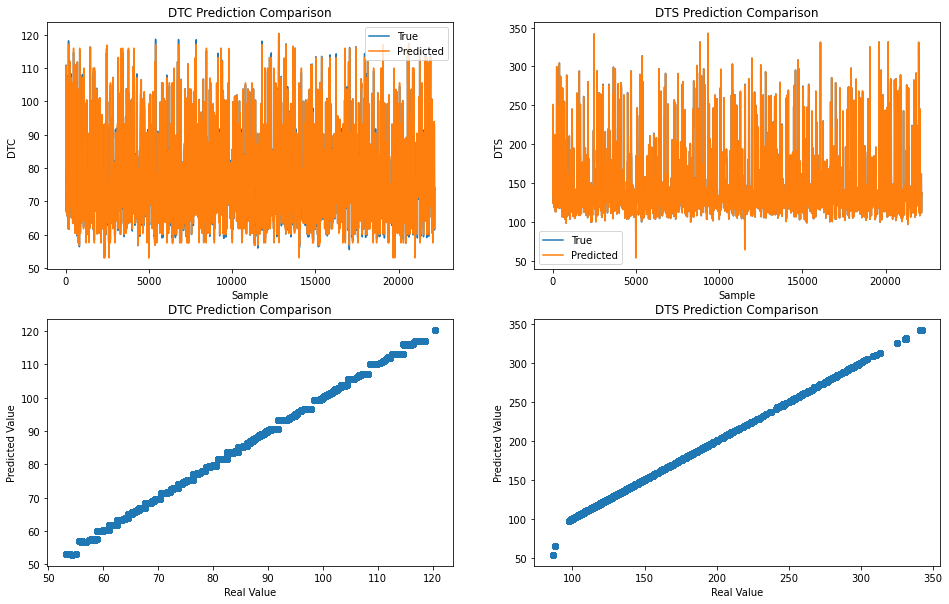

In [50]:
result_plot(preds,reals)

In [65]:
dt_true= dt[['DTC','DTS']]

In [67]:
# Compute estimations:
y_20test_ = np.concatenate([dtc.reshape(dtc.shape[0],1), dts.reshape(dts.shape[0],1)], axis=1) 
y_20true_ = dt_true.values

In [69]:
y_20test_

array([[ 66.90009, 124.23935],
       [ 66.90009, 124.23935],
       [ 66.90009, 124.23935],
       ...,
       [ 74.19155, 137.84264],
       [ 74.19155, 137.84264],
       [ 74.19155, 137.84264]], dtype=float32)

In [70]:
y_20true_

array([[ 67.5481, 124.2332],
       [ 67.5481, 124.2332],
       [ 67.5481, 124.2332],
       ...,
       [ 73.7051, 137.8335],
       [ 73.7051, 137.8335],
       [ 73.7051, 137.8335]])

RMSE of test data (#1 DTC): 0.43
RMSE of test data (#2 DTS): 0.87
Overall RMSE = 0.68


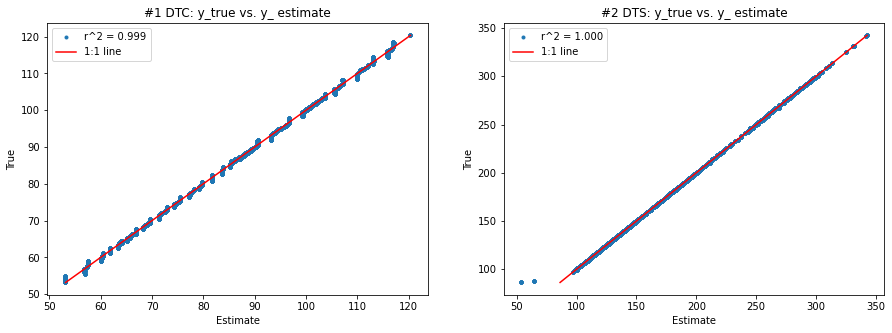

In [71]:
# Plot results:
plt.figure(figsize=(15,5))
i = 0
plt.subplot(1,2,i+1)
plt.plot(y_20test_[:,i], y_20true_[:,i], '.', label = 'r^2 = %.3f' % (r2_score(y_20true_[:,i], y_20test_[:,i])))
plt.plot([y_20true_[:,i].min(),y_20true_[:,i].max()],[y_20true_[:,i].min(),y_20true_[:,i].max()], 'r', label = '1:1 line')
plt.title('#1 DTC: y_true vs. y_ estimate'); plt.xlabel('Estimate'); plt.ylabel('True')
plt.legend()
i += 1
plt.subplot(1,2,i+1)
plt.plot(y_20test_[:,i], y_20true_[:,i], '.', label = 'r^2 = %.3f' % (r2_score(y_20true_[:,i], y_20test_[:,i])))
plt.plot([y_20true_[:,i].min(),y_20true_[:,i].max()],[y_20true_[:,i].min(),y_20true_[:,i].max()], 'r', label = '1:1 line')
plt.title('#2 DTS: y_true vs. y_ estimate'); plt.xlabel('Estimate'); plt.ylabel('True')
plt.legend()

MSE_0 = mean_squared_error(y_20true_[:,0], y_20test_[:,0]);
RMSE_0 = np.sqrt(mean_squared_error(y_20true_[:,0], y_20test_[:,0]));
MSE_1 = mean_squared_error(y_20true_[:,1], y_20test_[:,1]);
RMSE_1 = np.sqrt(mean_squared_error(y_20true_[:,1], y_20test_[:,1]));
print('RMSE of test data (#1 DTC): %.2f' %(RMSE_0))
print('RMSE of test data (#2 DTS): %.2f' %(RMSE_1))
print('Overall RMSE = %.2f' %np.sqrt((MSE_0+MSE_1)/2))